# Flow of this File 👇

### 🔸First part (FashionMNIST_part1.ipynb): 
#### We'll have a look at how the Neural network model with just Linear layers performs on an Image Classification problem
#### We'll also check how the performace changes when we add some Non-Linear layers in our model like ReLU layers

### 🔸Second Part (FashionMNIST_part2.ipynb):
#### We'll now implement Convolutional Neural Networks instead of Linear layers and observe the performance of our model

## <--------------------------------------------   x   -------------------------------------------------->

## General Steps:
1. Download Dataset
2. Create Datloader
3. Create a model 
4. Run Training and Evaluation loop
5. Evaluate the model

In [76]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import dataset  
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [77]:
train_data = datasets.FashionMNIST(root='Data', 
                                   train=True, 
                                   transform=torchvision.transforms.ToTensor(), # convert PIL images to torch tensors
                                   target_transform=None, # to transform the label or target
                                   download=True)

test_data = datasets.FashionMNIST(root='Data',
                                  train=False, # 'false' will download the test data 
                                  transform=torchvision.transforms.ToTensor(), # convert PIL images to torch tensors
                                  target_transform=None,
                                  download=True)

In [78]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [79]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

In [80]:
image, label = test_data[0]

In [81]:
print(f"Shape of the Image is {image.shape}") # C x H x W (color channels, height, width)
print(f"label value: {label}")

Shape of the Image is torch.Size([1, 28, 28])
label value: 9


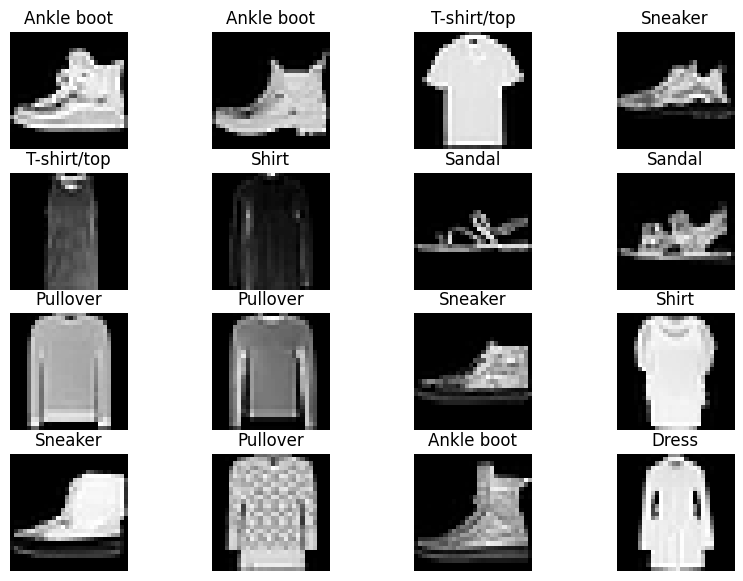

In [82]:
# Visualize the dataset

fig = plt.figure(figsize=(10,7))
row, col = 4, 4
for i in range(1, row*col+1):
    fig.add_subplot(row, col, i)
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    plt.imshow(img.squeeze(), cmap='gray') # squeeze is required to reduce img size from CxHxW to HxW, as matplotlib expects img in HxWXC or HxW
    plt.title(class_names[label])
    plt.axis(False)


In [83]:
# Create an Iterable for our dataset: Dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, BATCH_SIZE, shuffle=False)

print(f"Length of train_dataloader: {len(train_dataloader)}, with batch size of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)}, with batch size of {BATCH_SIZE}")

Length of train_dataloader: 1875, with batch size of 32
Length of test_dataloader: 313, with batch size of 32


train_feature shape: torch.Size([32, 1, 28, 28])
train_label shape: torch.Size([32])


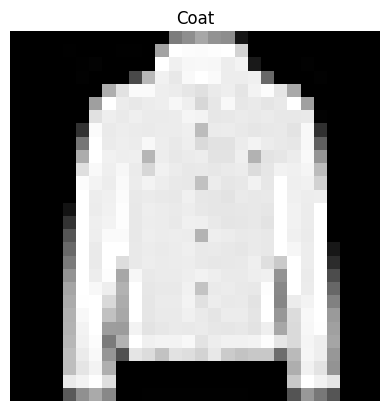

In [84]:
train_feature, train_label = next(iter(train_dataloader))
print(f"train_feature shape: {train_feature.shape}") # BxCxHxW [batch size, color channels, height, width]
print(f"train_label shape: {train_label.shape}")
random_idx = np.random.randint(0, len(train_label), 1)
img = train_feature[0].squeeze() # cause CxHxW is not the format for matplotlib 
plt.imshow(img, cmap='gray')
plt.axis(False)
plt.title(class_names[train_label[0]])
plt.show()

In [85]:
train_feature[0].squeeze().shape, train_feature[0].shape

(torch.Size([28, 28]), torch.Size([1, 28, 28]))

In [86]:
# Flatten layer
flatten = nn.Flatten()

# create a dummy img shape matrix
img = torch.rand((1, 28, 28))

# Flatten it using the flatten layer
flatten_img = flatten(img)

# Print out the shapes
print(f"shape of the img before flatten: {img.shape}")
print(f"shape of the img after flatten: {flatten_img.shape}")

shape of the img before flatten: torch.Size([1, 28, 28])
shape of the img after flatten: torch.Size([1, 784])


#### Linear layer model

In [87]:
# Create  a basic model

class ImageModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.nnLayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnLayers(x)

In [88]:
model = ImageModel(input_dim=784, hidden_dim=10, output_dim=len(class_names)) # 784 cause 28*28 is the dim of the input image 

In [89]:
model(train_feature[0])

tensor([[-0.3717,  0.0378,  0.0911, -0.2915, -0.0912, -0.2358, -0.3791,  0.0281,
          0.0183, -0.1238]], grad_fn=<AddmmBackward0>)

In [90]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [91]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

CnnModel(
  (nnLayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [96]:
# Train and Test the data
from tqdm.auto import tqdm
from helper_functions import accuracy_fn

# from torchmetrics import Accuracy
# accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

epochs = 10

for epoch in tqdm(range(epochs)):
    batch_train_loss = 0
    batch_train_acc = 0
    # X, y --> img, label
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        model.train()
        y_pred = model(X_train)
        train_loss = loss_fn(y_pred, y_train) 
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        # train_acc = accuracy(y_pred.argmax(dim=1), y_train) # argmax is to select the class that has the highest Logit value
        train_acc = accuracy_fn(y_true=y_train, y_pred=y_pred.argmax(dim=1)) # argmax is to select the class that has the highest Logit value

        batch_train_loss += train_loss
        batch_train_acc += train_acc

        if batch%400 == 0:
            print(f"Batch: {batch} | train acc: {train_acc}% | train loss: {train_loss}")

    batch_test_loss = 0
    batch_test_acc = 0
    model.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            y_pred_test = model(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            # test_acc = accuracy(y_pred_test.argmax(dim=1), y_test)
            test_acc = accuracy_fn(y_true=y_test, y_pred=y_pred_test.argmax(dim=1))
            batch_test_loss += test_loss
            batch_test_acc += test_acc

            if batch%400 == 0:
                print(f"Batch: {batch} | test acc: {test_acc}% | test loss: {test_loss}")


    print(f"Epoch: {epoch} | train loss: {batch_train_loss:.3f} | train acc: {(batch_train_acc/len(train_dataloader)):.2f}% | test loss: {batch_test_loss:.3f} | test acc: {(batch_test_acc/len(test_dataloader)):.2f}%")

  0%|          | 0/10 [00:00<?, ?it/s]

Batch: 0 | train acc: 87.5% | train loss: 0.4608452618122101
Batch: 400 | train acc: 87.5% | train loss: 0.5479253530502319
Batch: 800 | train acc: 78.125% | train loss: 0.5191322565078735
Batch: 1200 | train acc: 84.375% | train loss: 0.411877304315567
Batch: 1600 | train acc: 87.5% | train loss: 0.3375298082828522
Batch: 0 | test acc: 75.0% | test loss: 0.5256616473197937


 10%|█         | 1/10 [00:11<01:45, 11.76s/it]

Epoch: 0 | train loss: 892.484 | train acc: 83.54% | test loss: 154.857 | test acc: 82.82%
Batch: 0 | train acc: 93.75% | train loss: 0.25689786672592163
Batch: 400 | train acc: 81.25% | train loss: 0.3911307752132416
Batch: 800 | train acc: 84.375% | train loss: 0.45211324095726013
Batch: 1200 | train acc: 87.5% | train loss: 0.3636762797832489
Batch: 1600 | train acc: 90.625% | train loss: 0.36332881450653076
Batch: 0 | test acc: 78.125% | test loss: 0.4785672724246979


 20%|██        | 2/10 [00:23<01:32, 11.59s/it]

Epoch: 1 | train loss: 860.302 | train acc: 84.10% | test loss: 150.515 | test acc: 83.14%
Batch: 0 | train acc: 90.625% | train loss: 0.44972100853919983
Batch: 400 | train acc: 78.125% | train loss: 0.3725546896457672
Batch: 800 | train acc: 81.25% | train loss: 0.4227359890937805
Batch: 1200 | train acc: 90.625% | train loss: 0.4156177341938019
Batch: 1600 | train acc: 78.125% | train loss: 0.7246379852294922
Batch: 0 | test acc: 78.125% | test loss: 0.44588109850883484


 30%|███       | 3/10 [00:34<01:21, 11.58s/it]

Epoch: 2 | train loss: 839.481 | train acc: 84.50% | test loss: 148.334 | test acc: 83.32%
Batch: 0 | train acc: 96.875% | train loss: 0.2630278468132019
Batch: 400 | train acc: 87.5% | train loss: 0.5708531141281128
Batch: 800 | train acc: 84.375% | train loss: 0.38095197081565857
Batch: 1200 | train acc: 84.375% | train loss: 0.4467926323413849
Batch: 1600 | train acc: 87.5% | train loss: 0.47726497054100037
Batch: 0 | test acc: 78.125% | test loss: 0.473165363073349


 40%|████      | 4/10 [00:46<01:08, 11.47s/it]

Epoch: 3 | train loss: 822.615 | train acc: 84.80% | test loss: 146.701 | test acc: 83.49%
Batch: 0 | train acc: 87.5% | train loss: 0.37157657742500305
Batch: 400 | train acc: 84.375% | train loss: 0.49387234449386597
Batch: 800 | train acc: 87.5% | train loss: 0.3941379487514496
Batch: 1200 | train acc: 84.375% | train loss: 0.47095927596092224
Batch: 1600 | train acc: 84.375% | train loss: 0.3748835623264313
Batch: 0 | test acc: 87.5% | test loss: 0.39954301714897156


 50%|█████     | 5/10 [00:57<00:57, 11.49s/it]

Epoch: 4 | train loss: 811.016 | train acc: 85.07% | test loss: 144.396 | test acc: 83.73%
Batch: 0 | train acc: 75.0% | train loss: 0.8068385124206543
Batch: 400 | train acc: 81.25% | train loss: 0.4205677807331085
Batch: 800 | train acc: 90.625% | train loss: 0.5647761821746826
Batch: 1200 | train acc: 84.375% | train loss: 0.3837805390357971
Batch: 1600 | train acc: 84.375% | train loss: 0.30840685963630676
Batch: 0 | test acc: 84.375% | test loss: 0.4364588260650635


 60%|██████    | 6/10 [01:09<00:47, 11.77s/it]

Epoch: 5 | train loss: 799.523 | train acc: 85.22% | test loss: 144.945 | test acc: 83.79%
Batch: 0 | train acc: 65.625% | train loss: 0.7951475381851196
Batch: 400 | train acc: 93.75% | train loss: 0.23041561245918274
Batch: 800 | train acc: 93.75% | train loss: 0.24832405149936676
Batch: 1200 | train acc: 93.75% | train loss: 0.2267715036869049
Batch: 1600 | train acc: 71.875% | train loss: 0.6629634499549866
Batch: 0 | test acc: 87.5% | test loss: 0.41868114471435547


 70%|███████   | 7/10 [01:21<00:35, 11.84s/it]

Epoch: 6 | train loss: 790.843 | train acc: 85.40% | test loss: 147.823 | test acc: 83.61%
Batch: 0 | train acc: 93.75% | train loss: 0.23304159939289093
Batch: 400 | train acc: 78.125% | train loss: 0.5705399513244629
Batch: 800 | train acc: 78.125% | train loss: 0.5322349667549133
Batch: 1200 | train acc: 84.375% | train loss: 0.6247318387031555
Batch: 1600 | train acc: 90.625% | train loss: 0.3728994131088257
Batch: 0 | test acc: 84.375% | test loss: 0.408866822719574


 80%|████████  | 8/10 [01:33<00:23, 11.77s/it]

Epoch: 7 | train loss: 784.786 | train acc: 85.47% | test loss: 141.031 | test acc: 84.04%
Batch: 0 | train acc: 93.75% | train loss: 0.19966302812099457
Batch: 400 | train acc: 87.5% | train loss: 0.38247787952423096
Batch: 800 | train acc: 87.5% | train loss: 0.3313791751861572
Batch: 1200 | train acc: 96.875% | train loss: 0.1323443353176117
Batch: 1600 | train acc: 87.5% | train loss: 0.37831827998161316
Batch: 0 | test acc: 81.25% | test loss: 0.3878495395183563


 90%|█████████ | 9/10 [01:45<00:11, 11.79s/it]

Epoch: 8 | train loss: 778.883 | train acc: 85.66% | test loss: 142.311 | test acc: 83.84%
Batch: 0 | train acc: 81.25% | train loss: 0.42798835039138794
Batch: 400 | train acc: 90.625% | train loss: 0.16694773733615875
Batch: 800 | train acc: 81.25% | train loss: 0.5264855027198792
Batch: 1200 | train acc: 78.125% | train loss: 0.675643265247345
Batch: 1600 | train acc: 87.5% | train loss: 0.3009519875049591
Batch: 0 | test acc: 87.5% | test loss: 0.36623266339302063


100%|██████████| 10/10 [01:57<00:00, 11.77s/it]

Epoch: 9 | train loss: 772.399 | train acc: 85.73% | test loss: 142.455 | test acc: 84.01%


Text(0.5, 1.0, 'Sandal')

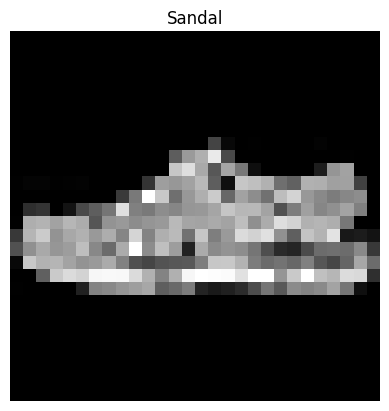

In [97]:
test_img, test_label = next(iter(test_dataloader))
random_idx = np.random.randint(0, len(test_img), 1)
plt.imshow(test_img[random_idx].squeeze(), cmap='gray')
plt.axis(False)
plt.title(class_names[test_label[random_idx]])


In [98]:
with torch.inference_mode():
    pred = model(test_img[random_idx].to(device))

print(f"Predicted class: {class_names[pred.argmax()]}")

Predicted class: Sandal


## Non-linear layers in the model

In [122]:
# A model with non-linear layers 
class ImageModel_2(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.nnLayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=hidden_dim),
            nn.ReLU(),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )

    def forward(self, x:torch.Tensor)->torch.Tensor:
        return self.nnLayers(x)

In [123]:
# Initiate a model
model_2 = ImageModel_2(input_dim=784, # these are the outputs from our flatten layer once our img with 28x28 dim passes through it 
                     hidden_dim=128, # set any no.of hidden layers, preferably in powers of 2
                     output_dim=10) # set the no.of output classes you have here
model_2.to(device)

CnnModel_2(
  (nnLayers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [126]:
# Initialize Loss fxn and Optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)

In [132]:
from torchmetrics import Accuracy
from tqdm.auto import tqdm

# Trian Loop
epochs = 10
accuracy = Accuracy(task='multiclass', num_classes=10).to(device)

# loop for each epoch
for epoch in tqdm(range(epochs)):
    batch_train_loss = 0
    batch_train_acc = 0

    # loop for each batch, each batch contain 32 images 
    for batch, (X_train, y_train) in enumerate(train_dataloader):
        X_train = X_train.to(device)
        y_train = y_train.to(device)

        model_2.train()
        y_pred = model_2(X_train)
        train_loss = loss_fn(y_pred, y_train)
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_acc = accuracy(y_pred, y_train) * 100
        # train_acc_2 = accuracy_fn(y_true=y_train, y_pred=y_pred.argmax(dim=1))

        batch_train_loss += train_loss
        batch_train_acc += train_acc

        if batch % 500 == 0:
            print(f"Batch: {batch} | Train loss: {train_loss:.3f} | Train acc: {(train_acc):.2f}%")
    
    # Model Eval loop
    batch_test_loss = 0
    batch_test_acc = 0

    model_2.eval()
    with torch.inference_mode():
        for batch, (X_test, y_test) in enumerate(test_dataloader):
            X_test = X_test.to(device)
            y_test = y_test.to(device)

            y_pred_test = model_2(X_test)
            test_loss = loss_fn(y_pred_test, y_test)
            test_acc = accuracy(y_pred_test, y_test) * 100
            # test_acc_2 = accuracy_fn(y_true=y_test, y_pred=y_pred_test.argmax(dim=1))

            batch_test_loss += test_loss
            batch_test_acc += test_acc
            
            if batch % 500 == 0:
                print(f"Batch: {batch} | Test loss: {test_loss:.3f} | Test acc: {(test_acc):.2f}%")

    print(f"Epoch: {epoch} | Train loss: {(batch_train_loss/len(train_dataloader)):.3f} | Train acc: {(batch_train_acc/len(train_dataloader)):.2f}% | \
          Test loss: {(batch_test_loss/len(test_dataloader)):.3f} | Test acc: {(batch_test_acc/len(test_dataloader)):.2f}% \n")


  0%|          | 0/10 [00:00<?, ?it/s]

Batch: 0 | Train loss: 0.372 | Train acc: 87.50%
Batch: 500 | Train loss: 0.244 | Train acc: 90.62%
Batch: 1000 | Train loss: 0.308 | Train acc: 93.75%
Batch: 1500 | Train loss: 0.595 | Train acc: 81.25%
Batch: 0 | Test loss: 0.314 | Test acc: 87.50%


 10%|█         | 1/10 [00:16<02:24, 16.06s/it]

Epoch: 0 | Train loss: 0.361 | Train acc: 87.33% |           Test loss: 0.405 | Test acc: 85.71% 

Batch: 0 | Train loss: 0.114 | Train acc: 96.88%
Batch: 500 | Train loss: 0.340 | Train acc: 87.50%
Batch: 1000 | Train loss: 0.217 | Train acc: 96.88%
Batch: 1500 | Train loss: 0.236 | Train acc: 90.62%
Batch: 0 | Test loss: 0.310 | Test acc: 87.50%


 20%|██        | 2/10 [00:30<02:01, 15.18s/it]

Epoch: 1 | Train loss: 0.360 | Train acc: 87.40% |           Test loss: 0.405 | Test acc: 85.55% 

Batch: 0 | Train loss: 0.240 | Train acc: 87.50%
Batch: 500 | Train loss: 0.302 | Train acc: 87.50%
Batch: 1000 | Train loss: 0.295 | Train acc: 93.75%
Batch: 1500 | Train loss: 0.275 | Train acc: 87.50%
Batch: 0 | Test loss: 0.306 | Test acc: 87.50%


 30%|███       | 3/10 [00:45<01:46, 15.23s/it]

Epoch: 2 | Train loss: 0.359 | Train acc: 87.38% |           Test loss: 0.403 | Test acc: 85.74% 

Batch: 0 | Train loss: 0.226 | Train acc: 90.62%
Batch: 500 | Train loss: 0.351 | Train acc: 90.62%
Batch: 1000 | Train loss: 0.225 | Train acc: 93.75%
Batch: 1500 | Train loss: 0.363 | Train acc: 87.50%
Batch: 0 | Test loss: 0.307 | Test acc: 90.62%


 40%|████      | 4/10 [01:00<01:29, 14.90s/it]

Epoch: 3 | Train loss: 0.358 | Train acc: 87.44% |           Test loss: 0.402 | Test acc: 85.66% 

Batch: 0 | Train loss: 0.409 | Train acc: 90.62%
Batch: 500 | Train loss: 0.402 | Train acc: 87.50%
Batch: 1000 | Train loss: 0.239 | Train acc: 90.62%
Batch: 1500 | Train loss: 0.252 | Train acc: 90.62%
Batch: 0 | Test loss: 0.314 | Test acc: 90.62%


 50%|█████     | 5/10 [01:15<01:14, 14.86s/it]

Epoch: 4 | Train loss: 0.357 | Train acc: 87.47% |           Test loss: 0.402 | Test acc: 85.77% 

Batch: 0 | Train loss: 0.245 | Train acc: 90.62%
Batch: 500 | Train loss: 0.547 | Train acc: 81.25%
Batch: 1000 | Train loss: 0.431 | Train acc: 87.50%
Batch: 1500 | Train loss: 0.236 | Train acc: 93.75%
Batch: 0 | Test loss: 0.314 | Test acc: 90.62%


 60%|██████    | 6/10 [01:31<01:01, 15.26s/it]

Epoch: 5 | Train loss: 0.356 | Train acc: 87.48% |           Test loss: 0.402 | Test acc: 85.61% 

Batch: 0 | Train loss: 0.375 | Train acc: 90.62%
Batch: 500 | Train loss: 0.250 | Train acc: 90.62%
Batch: 1000 | Train loss: 0.336 | Train acc: 87.50%
Batch: 1500 | Train loss: 0.125 | Train acc: 96.88%
Batch: 0 | Test loss: 0.312 | Test acc: 90.62%


 70%|███████   | 7/10 [01:46<00:45, 15.27s/it]

Epoch: 6 | Train loss: 0.355 | Train acc: 87.49% |           Test loss: 0.400 | Test acc: 85.82% 

Batch: 0 | Train loss: 0.225 | Train acc: 90.62%
Batch: 500 | Train loss: 0.298 | Train acc: 84.38%
Batch: 1000 | Train loss: 0.153 | Train acc: 96.88%
Batch: 1500 | Train loss: 0.188 | Train acc: 93.75%
Batch: 0 | Test loss: 0.296 | Test acc: 90.62%


 80%|████████  | 8/10 [02:01<00:30, 15.20s/it]

Epoch: 7 | Train loss: 0.354 | Train acc: 87.55% |           Test loss: 0.399 | Test acc: 85.84% 

Batch: 0 | Train loss: 0.399 | Train acc: 90.62%
Batch: 500 | Train loss: 0.314 | Train acc: 90.62%
Batch: 1000 | Train loss: 0.325 | Train acc: 90.62%
Batch: 1500 | Train loss: 0.479 | Train acc: 81.25%
Batch: 0 | Test loss: 0.300 | Test acc: 90.62%


 90%|█████████ | 9/10 [02:17<00:15, 15.37s/it]

Epoch: 8 | Train loss: 0.353 | Train acc: 87.54% |           Test loss: 0.399 | Test acc: 85.79% 

Batch: 0 | Train loss: 0.425 | Train acc: 87.50%
Batch: 500 | Train loss: 0.589 | Train acc: 75.00%
Batch: 1000 | Train loss: 0.293 | Train acc: 87.50%
Batch: 1500 | Train loss: 0.281 | Train acc: 81.25%
Batch: 0 | Test loss: 0.309 | Test acc: 90.62%


100%|██████████| 10/10 [02:32<00:00, 15.27s/it]

Epoch: 9 | Train loss: 0.352 | Train acc: 87.62% |           Test loss: 0.397 | Test acc: 85.88% 



#### We observed that both the models performance is almost the same where,
Linear layer model has 84% accuracy on test data | 
Non-Linear layer model has 85% accuracy on train data